In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

# 1. Check pearson r2

In [92]:
# Get and combine pearson r from log files
def combine_results(path='/data100t1/home/wanying/CCHC/lipidomics/20240405_rerun_fix_pearson_r_bug/output/class'):
    lipids, pearson_r_train, pvals_train, pearson_r_test, pvals_test = [], [], [], [], []
    c = 0
    for fn in os.listdir(path):
        if fn.endswith('log'):
            with open(os.path.join(path, fn)) as fh:
                line = fh.readline().strip()
                while line != '':
                    if line.startswith('root - INFO - # - output_prefix'): # Lipid name
                        lipids.append(line.split(': ')[-1])
                    elif line.startswith('root - INFO - # - Training set: pearson_r'):
                        tmp =line.split()
                        pearson_r_train.append(tmp[8].split('=')[-1][:-1]) # Remove the extra comma at the end
                        pvals_train.append(tmp[9].split('=')[-1])
                        
                        line = fh.readline().strip()
                        tmp =line.split()
                        pearson_r_test.append(tmp[8].split('=')[-1][:-1]) # Remove the extra comma at the end
                        pvals_test.append(tmp[9].split('=')[-1])
                        break
                    line = fh.readline().strip()
            c += 1
            print(f'\r# Processes {c}    ', flush=True, end='')
            
    df_performance = pd.DataFrame({'lipid':lipids, 'pearson_r_train':pearson_r_train, 'pvals_train':pvals_train,
                               'pearson_r_test':pearson_r_test, 'pvals_test':pvals_test})
    print()
    return df_performance

            

In [93]:
df_performance_class = combine_results(path='/data100t1/home/wanying/CCHC/lipidomics/20240405_rerun_fix_pearson_r_bug/output/class')
df_performance_class.to_csv(os.path.join(path, 'model_performance.txt'), sep='\t')

df_performance_species = combine_results(path='/data100t1/home/wanying/CCHC/lipidomics/20240405_rerun_fix_pearson_r_bug/output/species_v1')
df_performance_species.to_csv(os.path.join(path, 'model_performance.txt'), sep='\t')

# Processes 49    
# Processes 830    


In [95]:
for col in ['pearson_r_train', 'pvals_train', 'pearson_r_test', 'pvals_test']:
    df_performance_class[col] = pd.to_numeric(df_performance_class[col])
    df_performance_species[col] = pd.to_numeric(df_performance_species[col])

In [96]:
df_performance_species.head(2)

,lipid,pearson_r_train,pvals_train,pearson_r_test,pvals_test
0,LPE(18:0) [sn1],0.665712,3.499455e-206,0.136970,0.000337
1,PIP1(38:4),0.605527,2.678387e-161,0.110752,0.003806


In [115]:
# Load Phillip's model performance in traning set
df_phillip = pd.read_csv('~/CCHC/lipidomics/20240204_rerun_to_compare_with_phillip/Phillip_rerun/Reanalyzed_Lipid_Model_Results.csv')
df_phillip.head()



,Lipid,R,R_Squared,P
0,LPC-26_0-_[sn1],0.666155,0.443762,1.110000e-187
1,PE-18_0_20_3-_-a-,0.659351,0.434743,1.370000e-182
2,FA-18_0-,0.657561,0.432386,2.830000e-181
3,PE-P-18_0-20_3-_-a-,0.650402,0.423023,4.270000e-176
4,Cer-d17_1-24_1-,0.649413,0.421738,2.160000e-175


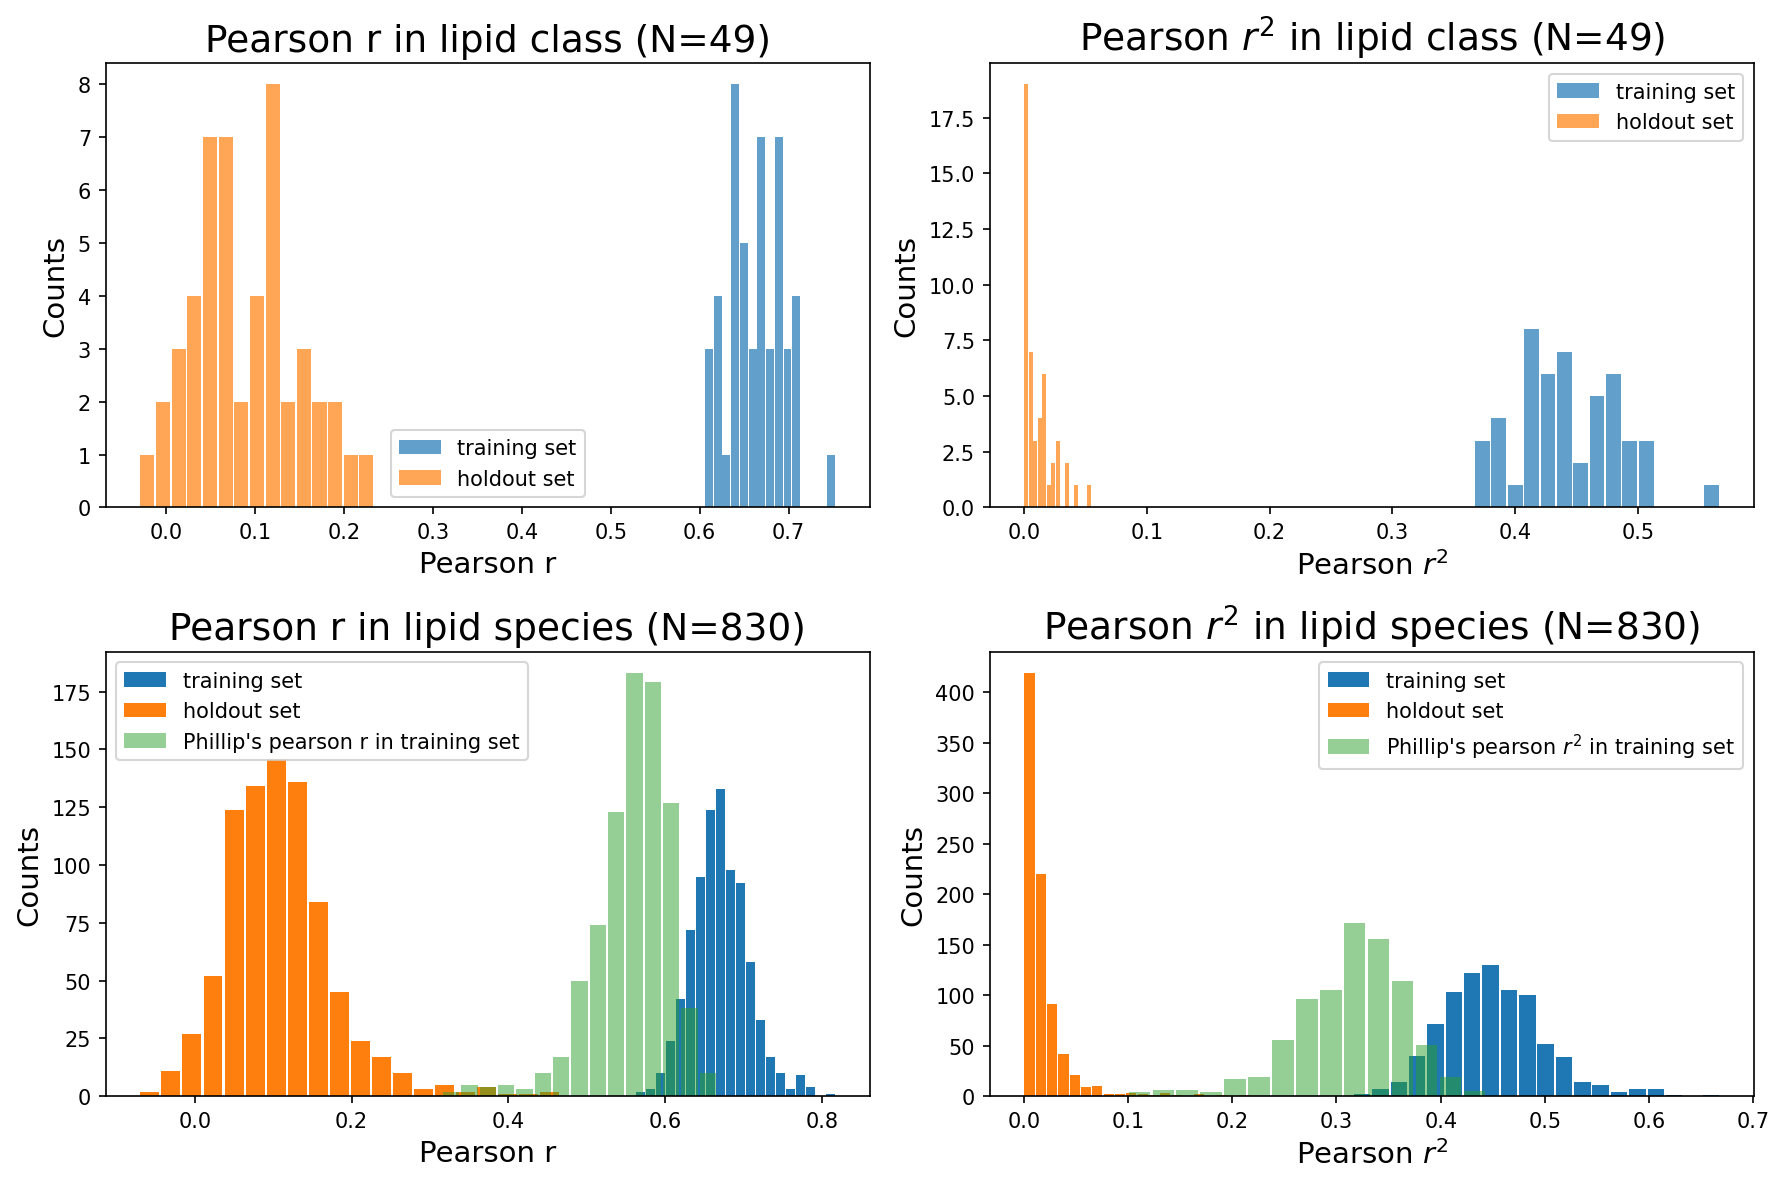

In [124]:
# Plot
fig, ax = plt.subplots(nrows=2, ncols=2, dpi=150, figsize=(12,8))
ax[0,0].hist(df_performance_class['pearson_r_train'], bins=15, rwidth=0.9, alpha=0.7, label='training set')
ax[0,0].hist(df_performance_class['pearson_r_test'], bins=15, rwidth=0.9, alpha=0.7, label='holdout set')
ax[0,0].set_title('Pearson r in lipid class (N=49)', fontsize=18)
ax[0,0].set_ylabel('Counts', fontsize=14)
ax[0,0].set_xlabel('Pearson r', fontsize=14)
ax[0,0].legend()

ax[0,1].hist(df_performance_class['pearson_r_train']**2, bins=15, rwidth=0.9, alpha=0.7, label='training set')
ax[0,1].hist(df_performance_class['pearson_r_test']**2, bins=15, rwidth=0.9, alpha=0.7, label='holdout set')
ax[0,1].set_title('Pearson $r^2$ in lipid class (N=49)', fontsize=18)
ax[0,1].set_ylabel('Counts', fontsize=14)
ax[0,1].set_xlabel('Pearson $r^2$', fontsize=14)
ax[0,1].legend()

ax[1,0].hist(df_performance_species['pearson_r_train'], bins=20, rwidth=0.9, label='training set')
ax[1,0].hist(df_performance_species['pearson_r_test'], bins=20, rwidth=0.9, label='holdout set')
ax[1,0].hist(df_phillip['R'], bins=15, rwidth=0.9, alpha=0.5, label="Phillip's pearson r in training set")
ax[1,0].set_title('Pearson r in lipid species (N=830)', fontsize=18)
ax[1,0].set_ylabel('Counts', fontsize=14)
ax[1,0].set_xlabel('Pearson r', fontsize=14)
ax[1,0].legend()

ax[1,1].hist(df_performance_species['pearson_r_train']**2, bins=20, rwidth=0.9, label='training set')
ax[1,1].hist(df_performance_species['pearson_r_test']**2, bins=20, rwidth=0.9, label='holdout set')
ax[1,1].hist(df_phillip['R_Squared'], bins=15, rwidth=0.9, alpha=0.5, label="Phillip's pearson $r^2$ in training set")
ax[1,1].set_title('Pearson $r^2$ in lipid species (N=830)', fontsize=18)
ax[1,1].set_ylabel('Counts', fontsize=14)
ax[1,1].set_xlabel('Pearson $r^2$', fontsize=14)
ax[1,1].legend()

fig.tight_layout()

In [164]:
# Plot heritability against pearson r
# Add a column for merging
df_performance_species['Lipid_name'] = df_performance_species['lipid'].apply(lambda x: x.replace('_', '-').replace('(', '-').replace(')', '-').replace('/', '-').replace(' ', '_'))
df_performance_species['Lipid_name_for_merge'] = df_performance_species['Lipid_name'].apply(lambda x: x.replace('_', '-'))

df_h2 = pd.read_csv('/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/outputs/fastGWA/heritability_estimation/merged_heritability_results/heritability_species.train_only.txt',
                    sep='\t')
df_h2['Lipid_name_for_merge'] = df_h2['Lipid_name'].apply(lambda x: x.replace('_', '-'))

df_h2_r2_species = df_performance_species.merge(df_h2, on='Lipid_name_for_merge').sort_values(by='h2').reset_index()
# Calculate 95% CI
df_h2_r2_species['95CI'] = 1.96*df_h2_r2_species['se']
display(df_h2_r2_species.head(2))
print(df_h2_r2_species.shape)
# Some lipids are loss due to name mismatch

,index,lipid,pearson_r_train,pvals_train,pearson_r_test,pvals_test,Lipid_name_x,Lipid_name_for_merge,Lipid_name_y,h2,se,95CI
0,711,TG(49:1) [NL-16:1],0.641115,1.281610e-186,0.032779,0.393080,TG-49:1-_[NL-16:1],TG-49:1--[NL-16:1],TG-49:1-_[NL-16:1],0.000001,0.188082,0.368641
1,412,S1P(d18:2),0.648118,5.275006e-192,0.059587,0.120305,S1P-d18:2-,S1P-d18:2-,S1P-d18:2-,0.000001,0.186483,0.365507


(829, 12)


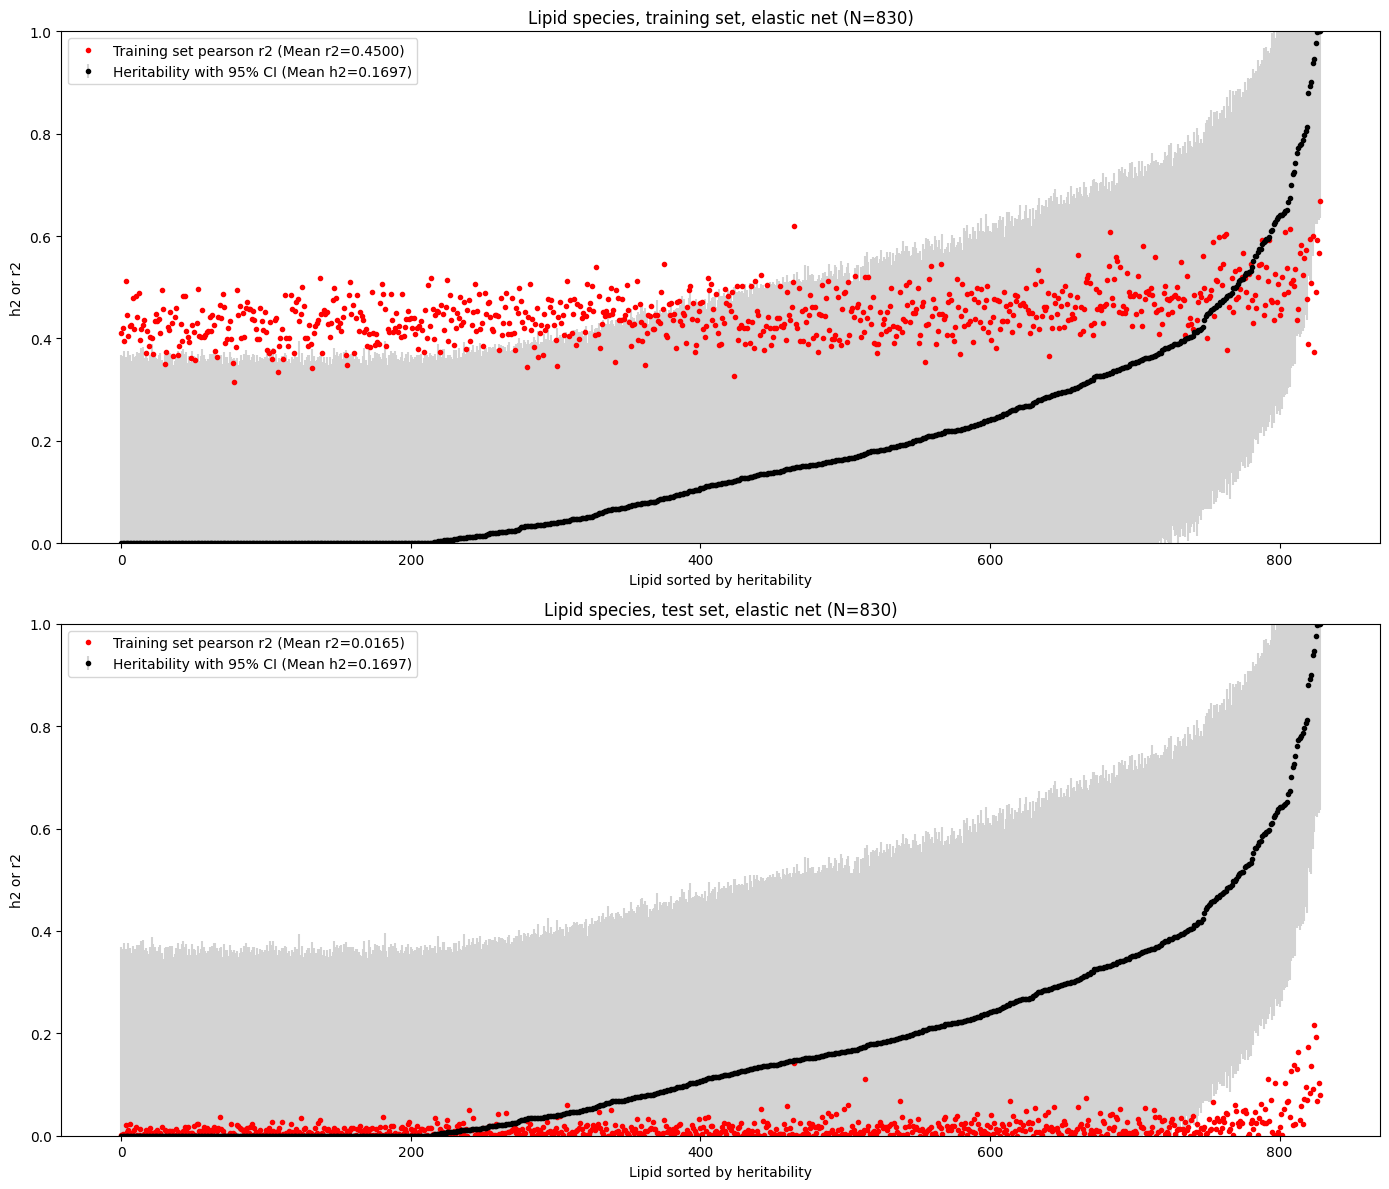

In [165]:
# Plot heritability vs. model performance
# threshold = 0.1
# mask = df_performance_heritability['heritability_unrelated']>threshold
# fig, ax = plt.subplots(dpi=100, figsize=(12, 4))
# ax.plot(df_performance_heritability[mask]['heritability_unrelated'],
#         df_performance_heritability[mask]['pearson_r2'],
#         ls='', marker='.', color='r', label='Test set pearson r2')
# ax.set_title('Lasso (pearson r2)')
# ax.set_xlabel('Heritability')
# ax.set_ylabel('Pearson r2')
fig, ax = plt.subplots(dpi=100, figsize=(14, 12), nrows=2)
ax[0].errorbar(df_h2_r2_species.index, df_h2_r2_species['h2'],
               yerr=df_h2_r2_species['95CI'], ls='', marker='.', color='k', ecolor='lightgrey',
               label=f"Heritability with 95% CI (Mean h2={df_h2_r2_species['h2'].mean():.4f})")
ax[0].plot(df_h2_r2_species.index, df_h2_r2_species['pearson_r_train']**2,
           ls='', marker='.', color='r', label=f"Training set pearson r2 (Mean r2={(df_h2_r2_species['pearson_r_train']**2).mean():.4f})")
ax[0].set_ylim(bottom=0, top=1)
ax[0].set_title('Lipid species, training set, elastic net (N=830)')
ax[0].set_xlabel('Lipid sorted by heritability')
ax[0].set_ylabel('h2 or r2')
ax[0].legend()

ax[1].errorbar(df_h2_r2_species.index, df_h2_r2_species['h2'],
               yerr=df_h2_r2_species['95CI'], ls='', marker='.', color='k', ecolor='lightgrey',
               label=f"Heritability with 95% CI (Mean h2={df_h2_r2_species['h2'].mean():.4f})")
ax[1].plot(df_h2_r2_species.index, df_h2_r2_species['pearson_r_test']**2,
           ls='', marker='.', color='r', label=f"Training set pearson r2 (Mean r2={(df_h2_r2_species['pearson_r_test']**2).mean():.4f})")
ax[1].set_ylim(bottom=0, top=1)
ax[1].set_title('Lipid species, test set, elastic net (N=830)')
ax[1].set_xlabel('Lipid sorted by heritability')
ax[1].set_ylabel('h2 or r2')
ax[1].legend()

fig.tight_layout()

# 2. Check other spearman r

In [7]:
# Get and combine pearson r from log files
def combine_results_spearman(path='/data100t1/home/wanying/CCHC/lipidomics/20240405_rerun_fix_pearson_r_bug/output/class'):
    lipids, spearman_r_train, pvals_train, spearman_r_test, pvals_test = [], [], [], [], []
    c = 0
    for fn in os.listdir(path):
        if fn.endswith('log'):
            with open(os.path.join(path, fn)) as fh:
                line = fh.readline().strip()
                while line != '':
                    if line.startswith('root - INFO - # - output_prefix'): # Lipid name
                        lipids.append(line.split(': ')[-1])
                    elif line.startswith('root - INFO - # - Training set: spearman_r'):
                        tmp =line.split()
                        spearman_r_train.append(tmp[8].split('=')[-1][:-1]) # Remove the extra comma at the end
                        pvals_train.append(tmp[9].split('=')[-1])
                        
                        line = fh.readline().strip()
                        tmp =line.split()
                        spearman_r_test.append(tmp[8].split('=')[-1][:-1]) # Remove the extra comma at the end
                        pvals_test.append(tmp[9].split('=')[-1])
                        break
                    line = fh.readline().strip()
            c += 1
            print(f'\r# Processes {c}    ', flush=True, end='')
            
    df_performance = pd.DataFrame({'lipid':lipids[:len(spearman_r_train)], 'spearman_r_train':spearman_r_train, 'pvals_train':pvals_train,
                                   'spearman_r_test':spearman_r_test, 'pvals_test':pvals_test})
    print()
    return df_performance

            

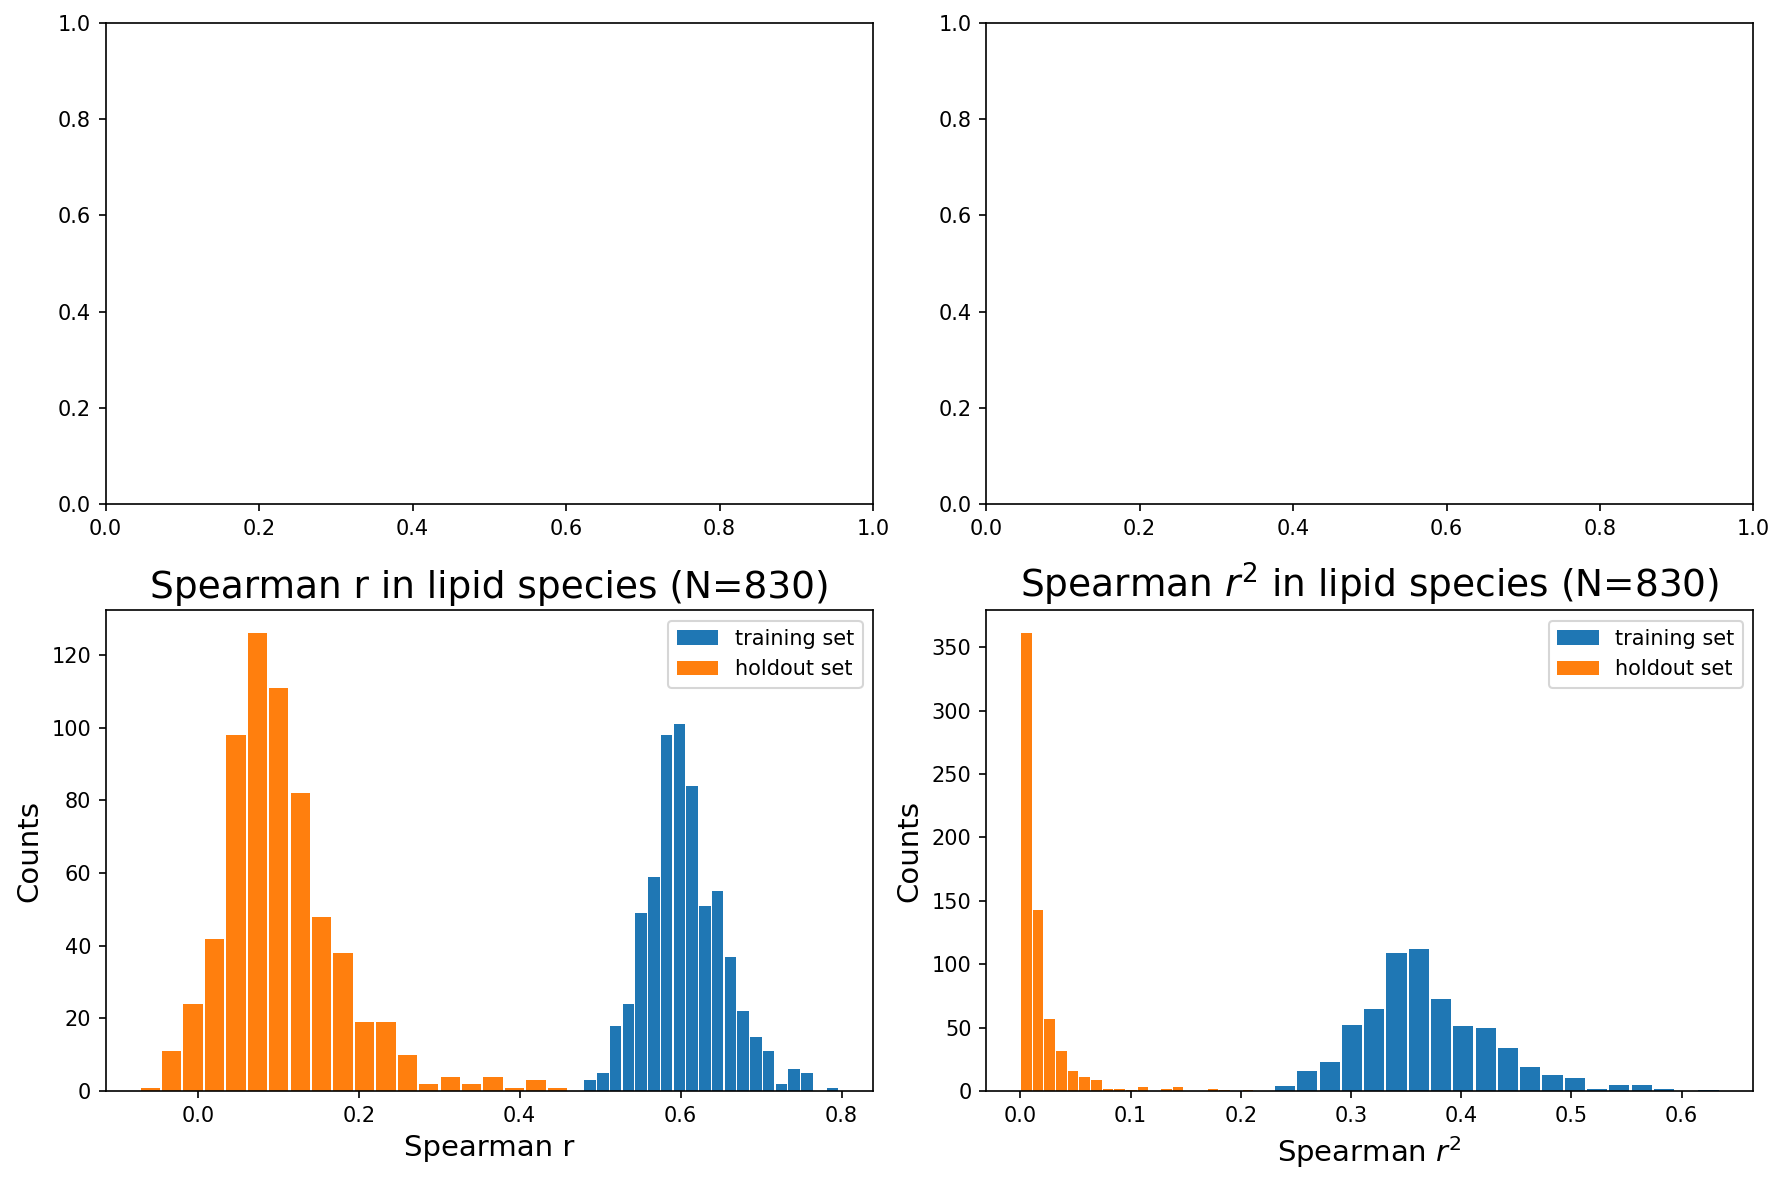

In [12]:
# Plot spearman r
path='/data100t1/home/wanying/CCHC/lipidomics/20240405_rerun_fix_pearson_r_bug/output/species'
df_performance_species = combine_results_spearman(path='/data100t1/home/wanying/CCHC/lipidomics/20240405_rerun_fix_pearson_r_bug/output/species')
df_performance_species.to_csv(os.path.join(path, 'model_performance.spearmanr.txt'), sep='\t')

for col in ['spearman_r_train', 'pvals_train', 'spearman_r_test', 'pvals_test']:
    df_performance_species[col] = pd.to_numeric(df_performance_species[col])
    
# Plot
fig, ax = plt.subplots(nrows=2, ncols=2, dpi=150, figsize=(12,8))
# ax[0,0].hist(df_performance_class['pearson_r_train'], bins=15, rwidth=0.9, alpha=0.7, label='training set')
# ax[0,0].hist(df_performance_class['pearson_r_test'], bins=15, rwidth=0.9, alpha=0.7, label='holdout set')
# ax[0,0].set_title('Pearson r in lipid class (N=49)', fontsize=18)
# ax[0,0].set_ylabel('Counts', fontsize=14)
# ax[0,0].set_xlabel('Pearson r', fontsize=14)
# ax[0,0].legend()

# ax[0,1].hist(df_performance_class['pearson_r_train']**2, bins=15, rwidth=0.9, alpha=0.7, label='training set')
# ax[0,1].hist(df_performance_class['pearson_r_test']**2, bins=15, rwidth=0.9, alpha=0.7, label='holdout set')
# ax[0,1].set_title('Pearson $r^2$ in lipid class (N=49)', fontsize=18)
# ax[0,1].set_ylabel('Counts', fontsize=14)
# ax[0,1].set_xlabel('Pearson $r^2$', fontsize=14)
# ax[0,1].legend()

ax[1,0].hist(df_performance_species['spearman_r_train'], bins=20, rwidth=0.9, label='training set')
ax[1,0].hist(df_performance_species['spearman_r_test'], bins=20, rwidth=0.9, label='holdout set')
ax[1,0].set_title('Spearman r in lipid species (N=830)', fontsize=18)
ax[1,0].set_ylabel('Counts', fontsize=14)
ax[1,0].set_xlabel('Spearman r', fontsize=14)
ax[1,0].legend()

ax[1,1].hist(df_performance_species['spearman_r_train']**2, bins=20, rwidth=0.9, label='training set')
ax[1,1].hist(df_performance_species['spearman_r_test']**2, bins=20, rwidth=0.9, label='holdout set')
ax[1,1].set_title('Spearman $r^2$ in lipid species (N=830)', fontsize=18)
ax[1,1].set_ylabel('Counts', fontsize=14)
ax[1,1].set_xlabel('Spearman $r^2$', fontsize=14)
ax[1,1].legend()

fig.tight_layout()

# 3. Check effect size and p value in GWAS result
Do the SNPs have small pvalues but also small betas? (So the model will not be predictive)

In [ ]:
path